In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch.nn as nn
import torch
import torch.optim as optim
import pickle
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader,Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import PIL.Image as Image
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
train_on_gpu = True
from sklearn.model_selection import train_test_split

# 1. Bounding Box Model

In [0]:
with open('/content/drive/My Drive/dataset_whale/cropping.txt', 'rt') as f: data = f.read().split('\n')[:-1]
data = [line.split(',') for line in data]
data = [(p,[(int(coord[i]),int(coord[i+1])) for i in range(0,len(coord),2)]) for p,*coord in data]

In [0]:
from PIL import Image as pil_image
from PIL.ImageDraw import Draw
from os.path import isfile

def expand_path(p):
    if isfile('/content/drive/My Drive/dataset_whale/train/' + p): return '/content/drive/My Drive/dataset_whale/train/' + p
    if isfile('/content/drive/My Drive/dataset_whale/test/' + p): return '/content/drive/My Drive/dataset_whale/test/' + p
    return p

def read_raw_image(p):
    return pil_image.open(expand_path(p))

def draw_dot(draw, x, y):
    draw.ellipse(((x-5,y-5),(x+5,y+5)), fill='red', outline='red')

def draw_dots(draw, coordinates):
    for x,y in coordinates: draw_dot(draw, x, y)

def bounding_rectangle(list):
    x0, y0 = list[0]
    x1, y1 = x0, y0
    for x,y in list[1:]:
        x0 = min(x0, x)
        y0 = min(y0, y)
        x1 = max(x1, x)
        y1 = max(y1, y)
    return x0,y0,x1,y1

filename,coordinates = data[0]
box = bounding_rectangle(coordinates)
img = read_raw_image(filename)
draw = Draw(img)
draw_dots(draw, coordinates)
draw.rectangle(box, outline='red')
img

In [0]:
img_shape  = (224,224,1)
anisotropy = 2.15

In [0]:
import random
import numpy as np
from scipy.ndimage import affine_transform
from keras.preprocessing.image import img_to_array

# Read an image as black&white numpy array
def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

# Compute the coordinate transformation required to center the pictures, padding as required.
def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

# Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)

# Read an image for validation, i.e. without data augmentation.
def read_for_validation(p):
    x  = read_array(p)
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t 

# Read an image for training, i.e. including a random affine transformation
def read_for_training(p):
    x  = read_array(p)
    t  = build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.9, 1.0),
            random.uniform(0.9, 1.0),
            random.uniform(-0.05*img_shape[0], 0.05*img_shape[0]),
            random.uniform(-0.05*img_shape[1], 0.05*img_shape[1]))
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t   

# Transform corrdinates according to the provided affine transformation
def coord_transform(list, trans):
    result = []
    for x,y in list:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result

In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=200, random_state=1)
train += train
train += train
train += train
train += train
len(train),len(val)

In [0]:
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from keras import backend as K
from keras.preprocessing.image import array_to_img
from numpy.linalg import inv as mat_inv

def show_whale(imgs, per_row=5):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

val_a = np.zeros((len(val),)+img_shape,dtype=K.floatx()) # Preprocess validation images 
val_b = np.zeros((len(val),4),dtype=K.floatx()) # Preprocess bounding boxes
for i,(p,coords) in enumerate(tqdm_notebook(val)):
    img,trans      = read_for_validation(p)
    coords         = coord_transform(coords, mat_inv(trans))
    x0,y0,x1,y1    = bounding_rectangle(coords)
    val_a[i,:,:,:] = img
    val_b[i,0]     = x0
    val_b[i,1]     = y0
    val_b[i,2]     = x1
    val_b[i,3]     = y1

idx  = 1
img  = array_to_img(val_a[idx])
img  = img.convert('RGB')
draw = Draw(img)
draw.rectangle(val_b[idx], outline='red')
show_whale([read_raw_image(val[idx][0]), img], per_row=2)

In [0]:
from keras.utils import Sequence

class TrainingData(Sequence):
    def __init__(self, batch_size=32):
        super(TrainingData, self).__init__()
        self.batch_size = batch_size
    def __getitem__(self, index):
        start = self.batch_size*index;
        end   = min(len(train), start + self.batch_size)
        size  = end - start
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        b     = np.zeros((size,4), dtype=K.floatx())
        for i,(p,coords) in enumerate(train[start:end]):
            img,trans   = read_for_training(p)
            coords      = coord_transform(coords, mat_inv(trans))
            x0,y0,x1,y1 = bounding_rectangle(coords)
            a[i,:,:,:]  = img
            b[i,0]      = x0
            b[i,1]      = y0
            b[i,2]      = x1
            b[i,3]      = y1
        return a,b
    def __len__(self):
        return (len(train) + self.batch_size - 1)//self.batch_size

random.seed(1)
a, b = TrainingData(batch_size=5)[1]
img  = array_to_img(a[0])
img  = img.convert('RGB')
draw = Draw(img)
draw.rectangle(b[0], outline='red')
show_whale([read_raw_image(train[0][0]), img], per_row=2)

In [0]:
from keras.engine.topology import Input
from keras.layers import BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Model

def build_model(with_dropout=True):
    kwargs     = {'activation':'relu', 'padding':'same'}
    conv_drop  = 0.2
    dense_drop = 0.5
    inp        = Input(shape=img_shape)

    x = inp

    x = Conv2D(64, (9, 9), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    h = MaxPooling2D(pool_size=(1, int(x.shape[2])))(x)
    h = Flatten()(h)
    if with_dropout: h = Dropout(dense_drop)(h)
    h = Dense(16, activation='relu')(h)

    v = MaxPooling2D(pool_size=(int(x.shape[1]), 1))(x)
    v = Flatten()(v)
    if with_dropout: v = Dropout(dense_drop)(v)
    v = Dense(16, activation='relu')(v)

    x = Concatenate()([h,v])
    if with_dropout: x = Dropout(0.5)(x)
    x = Dense(4, activation='linear')(x)
    return Model(inp,x)

model = build_model(with_dropout=True)

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

for num in range(1, 4):
    model_name = 'cropping-%01d.h5' % num
    print(model_name)
    model.compile(Adam(lr=0.032), loss='mean_squared_error')
    model.fit_generator(
        TrainingData(), epochs=50, max_queue_size=12, workers=4, verbose=1,
        validation_data=(val_a, val_b),
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=9, min_delta=0.1, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.1, factor=0.25, min_lr=0.002, verbose=1),
            ModelCheckpoint(model_name, save_best_only=True, save_weights_only=True),
        ])
    model.load_weights(model_name)
    model.evaluate(val_a, val_b, verbose=0)

In [0]:
model.load_weights('cropping-1.h5')
loss1 = model.evaluate(val_a, val_b, verbose=0)
model.load_weights('cropping-2.h5')
loss2 = model.evaluate(val_a, val_b, verbose=0)
model.load_weights('cropping-3.h5')
loss3 = model.evaluate(val_a, val_b, verbose=0)
model_name = 'cropping-1.h5'
if loss2 <= loss1 and loss2 < loss3: model_name = 'cropping-2.h5'
if loss3 <= loss1 and loss3 <= loss2: model_name = 'cropping-3.h5'
model.load_weights(model_name)
loss1, loss2, loss3, model_name

model2 = build_model(with_dropout=False)
model2.load_weights(model_name)
model2.summary()

model2.compile(Adam(lr=0.002), loss='mean_squared_error')
model2.evaluate(val_a, val_b, verbose=0)

In [0]:
# Recompute the mean and variance running average without dropout
for layer in model2.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False
model2.compile(Adam(lr=0.002), loss='mean_squared_error')
model2.fit_generator(TrainingData(), epochs=1, max_queue_size=12, workers=6, verbose=1, validation_data=(val_a, val_b))
for layer in model2.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True
model2.compile(Adam(lr=0.002), loss='mean_squared_error')
model2.save('cropping.model')

In [0]:
images = []
for i,(p,coords) in enumerate(val[:25]):
    a         = val_a[i:i+1]
    rect1     = val_b[i]
    rect2     = model2.predict(a).squeeze()
    img       = array_to_img(a[0]).convert('RGB')
    draw      = Draw(img)
    draw.rectangle(rect1, outline='red')
    draw.rectangle(rect2, outline='yellow')
    images.append(img)
show_whale(images)

In [0]:
from pandas import read_csv

tagged = [p for _,p,_ in read_csv('../input/whale-categorization-playground/train.csv').to_records()]
submit = [p for _,p,_ in read_csv('../input/whale-categorization-playground/sample_submission.csv').to_records()]
join = tagged + submit
len(join)

p2bb = {}
for i,(p,coords) in enumerate(data): p2bb[p] = bounding_rectangle(coords)
len(p2bb)

# For other pictures, evaluate the model.
p2bb = {}
for p in tqdm_notebook(join):
    if p not in p2bb:
        img,trans         = read_for_validation(p)
        a                 = np.expand_dims(img, axis=0)
        x0, y0, x1, y1    = model2.predict(a).squeeze()
        (u0, v0),(u1, v1) = coord_transform([(x0,y0),(x1,y1)], trans)
        p2bb[p]           = (u0, v0, u1, v1)

In [0]:
import pickle

with open('bounding-box.pickle', 'wb') as f: pickle.dump(p2bb, f)

import os

os.remove('cropping-1.h5')
os.remove('cropping-2.h5')
os.remove('cropping-3.h5')

!ls *.pickle *.model

# 2. Image Preprocessing

In [1]:
import os

import PIL
from PIL import Image
from PIL.ImageDraw import Draw
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from scipy.ndimage import affine_transform
from keras import backend as K

import pandas as pd
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
MODEL_BASE = '/content/drive/My Drive/dataset_whale/'
TRAIN_DATA = '/content/drive/My Drive/dataset_whale/train'
TEST_DATA = '/content/drive/My Drive/dataset_whale/test_new'

In [0]:
model = load_model(os.path.join(MODEL_BASE, 'cropping.model'))

In [0]:
train_paths = [os.path.join(TRAIN_DATA, img) for img in os.listdir(TRAIN_DATA)]
test_paths = [os.path.join(TEST_DATA, img) for img in os.listdir(TEST_DATA)]

In [0]:
from PIL import Image as pil_image

# Define useful constants
img_shape  = (128,128,1)
anisotropy = 2.15

def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

# Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)

def read_raw_image(p):
    return pil_image.open(p)

def read_for_validation(x):
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x, t

def coord_transform(list, trans):
    result = []
    for x,y in list:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result

def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

def make_bbox(p):
    raw = read_array(p)
    width, height = raw.shape[1], raw.shape[0]
    img,trans         = read_for_validation(raw)
    a                 = np.expand_dims(img, axis=0)
    x0, y0, x1, y1    = model.predict(a).squeeze()
    (u0, v0),(u1, v1) = coord_transform([(x0,y0),(x1,y1)], trans)
    bbox = [max(u0,0), max(v0,0), min(u1,width), min(v1,height)]
    if bbox[0] >= bbox[2] or bbox[1] >= bbox[3]:
        bbox = [0,0,width,height]
    return bbox

In [25]:
from tqdm import tqdm
bbox_df = pd.DataFrame(columns=['Image','x0','y0','x1','y1']).set_index('Image')

for img in tqdm(train_paths):
    bbox_df.loc[img] = make_bbox(os.path.join(TRAIN_DATA,img))
    
for img in tqdm(test_paths):
    bbox_df.loc[img] = make_bbox(os.path.join(TEST_DATA,img))

bbox_df.to_csv("/content/drive/My Drive/dataset_whale/bounding_boxes.csv")



  0%|          | 0/9850 [00:00<?, ?it/s]

  0%|          | 1/9850 [00:00<49:17,  3.33it/s]

  0%|          | 8/9850 [00:00<35:13,  4.66it/s]

  0%|          | 14/9850 [00:00<25:29,  6.43it/s]

  0%|          | 21/9850 [00:00<18:33,  8.82it/s]

  0%|          | 27/9850 [00:00<13:55, 11.75it/s]

  0%|          | 33/9850 [00:00<10:35, 15.46it/s]

  0%|          | 40/9850 [00:00<08:09, 20.06it/s]

  0%|          | 48/9850 [00:01<06:25, 25.46it/s]

  1%|          | 54/9850 [00:01<05:21, 30.48it/s]

  1%|          | 60/9850 [00:01<04:35, 35.55it/s]

  1%|          | 66/9850 [00:01<04:03, 40.19it/s]

  1%|          | 72/9850 [00:01<03:52, 42.02it/s]

  1%|          | 79/9850 [00:01<03:28, 46.84it/s]

  1%|          | 85/9850 [00:01<03:20, 48.76it/s]

  1%|          | 92/9850 [00:01<03:05, 52.61it/s]

  1%|          | 100/9850 [00:01<02:50, 57.20it/s]

  1%|          | 107/9850 [00:02<02:45, 58.76it/s]

  1%|          | 114/9850 [00:02<02:51, 56.77it/s]

  1%|          | 120/9850 [00:02<02:5

In [26]:
bbox = pd.read_csv("/content/drive/My Drive/dataset_whale/bounding_boxes.csv")

bbox.loc()

,Image,x0,y0,x1,y1
0,/content/drive/My Drive/dataset_whale/train/f6...,21,198,993,418
1,/content/drive/My Drive/dataset_whale/train/f1...,19,5,1037,391
2,/content/drive/My Drive/dataset_whale/train/ef...,11,118,839,323
3,/content/drive/My Drive/dataset_whale/train/f0...,0,0,1044,233
4,/content/drive/My Drive/dataset_whale/train/ec...,18,125,614,269
...,...,...,...,...,...
25455,/content/drive/My Drive/dataset_whale/test_new...,36,102,840,297
25456,/content/drive/My Drive/dataset_whale/test_new...,41,96,1020,426
25457,/content/drive/My Drive/dataset_whale/test_new...,85,131,958,456
25458,/content/drive/My Drive/dataset_whale/test_new...,11,26,667,338


# 3. DenseNet Model

In [0]:
model_name = "densenet201"
num_classes = 4251
feature_extract = False

In [31]:
train = pd.read_csv("/content/drive/My Drive/dataset_whale/train.csv")
train.head()
df_train, df_val = train_test_split(train, test_size=0.2, random_state=63)

print(len(df_train))
print(len(df_val)) 

7880
1970


In [34]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(len(integer_encoded))

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded

    return y, label_encoder


y_train, le_train = prepare_labels(train['Id'])
#train:7880
#val:1970
y_train = y_train[range(7880)]
y_val = y_train[range(1970)]
#y_val, le_val = prepare_labels(df_val['Id'])
print(y_train.shape)
print(y_val.shape)

9850


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(7880, 4251)
(1970, 4251)


x0     22
y0    116
x1    962
y1    435
Name: /content/drive/My Drive/dataset_whale/train/f476dbfd.jpg, dtype: object


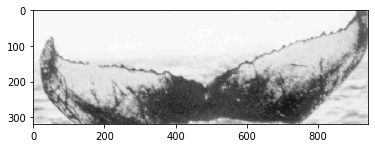

In [79]:
img_name = '/content/drive/My Drive/dataset_whale/train/f476dbfd.jpg'
image = Image.open(img_name).convert('RGB')
bbox = bbox_df.loc[img_name]
print(bbox)
x0, y0, x1, y1 = bbox['x0'], bbox['y0'], bbox['x1'],  bbox['y1']
if not (x0 >= x1 or y0 >= y1):
    image = image.crop((x0, y0, x1, y1))


image.show()
# img=Image.open('/content/drive/My Drive/dataset_whale/train/f3445000.jpg')
# plt.figure("dog")
plt.imshow(image)
plt.show()

In [0]:
# For train and val, datafolder = "../input/humpback-whale-identification/train"
# For test, datafolder = "../input/humpback-whale-identification/test"

# For train, datatype = "train"
# For val, datatype = "val"
# For test, datatype = "test"

# For train, y = y_train
# For val, y = y_val

# For train, df = df_train
# For val, df = df_val

# Finished # IMPORTANT: Remember to split y into train and val before creating object of this class
class Whaledataset(Dataset):
    def __init__(self, datafolder, datatype, transform, y, df):
        self.datafolder = datafolder
        self.datatype = datatype
        self.transform = transform
        self.y = y # y is same for both train and val
        if datatype =="train":
            self.df = df.values
        if datatype =="val":
            self.df = df.values
        # self.df not there for test because no df for test        
        self.image_list = [s for s in os.listdir(datafolder)]
        
    def __len__(self):
        if self.datatype == "train":
            return 7880
        elif self.datatype == "val":
            return 1970
        elif self.datatype == "test":
            return len(os.listdir(self.datafolder))
        
        #return len(os.listdir(self.image_list)) #Returns same value for train and val. Correct later
    
    def __getitem__(self, idx):
        if self.datatype =='train' or self.datatype =="val":
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_list[idx])
            label = np.zeros((1970,))

        image = Image.open(img_name).convert('RGB')
        bbox = bbox_df.loc[img_name]
        x0, y0, x1, y1 = bbox['x0'], bbox['y0'], bbox['x1'],  bbox['y1']
        if not (x0 >= x1 or y0 >= y1):
            image = image.crop((x0, y0, x1, y1))
        image = self.transform(image)
        if self.datatype == 'train' or self.datatype == "val":
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_list[idx]

In [81]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "densenet201":
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
train_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomAffine(30),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
val_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomAffine(30),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                              std = [0.229, 0.224, 0.225])
])

In [0]:
# Write function def accuracy here

def accuracy(outputs,labels):
    preds = outputs
    #print(type(preds), type(outputs))
    #preds_idx = np.argmax(preds, axis =1)
    #labels_idx = np.argmax(labels, axis =1)
    preds_idx = torch.argmax(preds, dim=1)
    ##print(preds_idx)
    labels_idx = torch.argmax(labels, dim=1)
    ##print(labels_idx)
    #preds_values, preds_idx = torch.max(preds, 1)
    #outputs_values, outputs_idx = torch.max(outputs, 1)
    #print(preds.shape)
    #print(labels.shape)
    return (preds_idx==labels_idx).float().sum()

train_datafolder = "/content/drive/My Drive/dataset_whale/train"
train_datatype = "train"
train_df = df_train
train_transform = train_transforms
train_y = y_train
batch_size = 32
num_workers = 0

val_datafolder = "/content/drive/My Drive/dataset_whale/train"
val_datatype = "val"
val_df = df_val
val_transform = val_transforms
val_y = y_val
batch_size = 32
num_workers = 0


def train(batch_size = 32, epochs = 10, transform = None):
    tfmd_dataset = Whaledataset(datafolder = train_datafolder, datatype = train_datatype, df = train_df , 
                                transform = train_transform, y = train_y)
    dataloader = torch.utils.data.DataLoader(tfmd_dataset, batch_size = batch_size, shuffle=True, 
                                             num_workers=num_workers)
    
    val_dataset = Whaledataset(datafolder = val_datafolder, datatype = val_datatype, df = val_df , 
                                transform = val_transform, y = val_y)
    
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=True, 
                                             num_workers=num_workers)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
    
    if torch.cuda.is_available():
        model_ft.cuda()
        nn.DataParallel(model_ft)
        print("GPU")
    epoch_loss_data = []
    epoch_accuracy_data = []

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print(device)
    
    for epoch in range(1,epochs+1):  # loop over the dataset multiple times
        i = 0.0
        running_loss, running_loss_total, epoch_accuracy = 0.0, 0.0, 0.0
        val_running_loss, val_running_loss_total, val_epoch_accuracy = 0.0, 0.0, 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs
            inputs, labels = data
            labels = labels.double()
            inputs, labels = inputs.to(device), labels.to(device)
        
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model_ft(inputs).double()
            #print(outputs.size())
            #print(labels.size())
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            # print statistics
            epoch_accuracy += accuracy(outputs,labels)
            #print(epoch_accuracy)
            #running_epoch_acc = float(epoch_accuracy)/float((labels.size()[0] * (i+1)))
            running_loss += loss.item()
            #running_loss_total += loss.item()
            '''if i%30 == 29:
                print('[%d, %5d] loss: %.3f, epoch_accuracy: %f' % (epoch, i + 1, running_loss, running_epoch_acc))
                running_loss = 0.0'''
            
            '''if i%100 == 99:
                torch.save(model_ft.state_dict(), 'checkpoint')
                torch.save(optimizer.state_dict(), 'optimizer_checkpoint')
                with open('Running_loss.p','wb') as f:
                    pickle.dump(running_loss_total,f)
                with open('Running_accuracy.p','wb') as f:
                    pickle.dump(running_epoch_acc,f)
        epoch_accuracy_data.append(running_epoch_acc)
        epoch_loss_data.append(running_loss_total)'''
            
        epoch_accuracy = float(epoch_accuracy)/float(32 * (i+1))
        print('[%d, %5d] loss: %.3f, epoch_accuracy: %f' % (epoch, i + 1, running_loss, epoch_accuracy))
        running_loss = 0.0
        epoch_accuracy = 0.0
        
        for i, data in enumerate(val_dataloader,0):
            inputs, labels = data
            labels = labels.double()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_ft(inputs).double()
            loss = criterion(outputs, labels)
            val_epoch_accuracy += accuracy(outputs,labels)
            val_running_epoch_acc = float(val_epoch_accuracy)/float((labels.size()[0] * (i+1)))
            val_running_loss += loss.item()
            '''if i%30 == 29:
                print('[%d, %5d] val loss: %.3f, val_epoch_accuracy: %f' % (epoch, i + 1, val_running_loss, val_running_epoch_acc))
                val_running_loss = 0.0
            '''
        val_epoch_accuracy = float(val_epoch_accuracy)/float(32 * (i+1))    
        print('[%d, %5d] val loss: %.3f, val_epoch_accuracy: %f' % (epoch, i + 1, val_running_loss, val_epoch_accuracy))
        val_running_loss = 0.0
        val_epoch_accuracy = 0.0

In [0]:
train(transform=train_transforms,epochs=25,batch_size=32)

GPU
cuda:0


In [0]:
test_datafolder = "/content/drive/My Drive/dataset_whale/test"
test_datatype = "test"
test_transform = test_transforms
batch_size = 32
num_workers = 0
sub = pd.read_csv("/content/drive/My Drive/dataset_whale/sample_submission.csv")
def test(batch_size, transform, model):
    test_set = Whaledataset(datafolder = test_datafolder, datatype = test_datatype, transform = test_transform, y = y_train, df = df_train)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)
    model.cuda()
    model.eval()
    for (data, target, name) in test_loader:
        data = data.cuda()
        output = model(data)
        print(output)
        output = output.cpu().detach().numpy()
        for i, (e, n) in enumerate(list(zip(output, name))):
            sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le_train.inverse_transform(e.argsort()[-5:][::-1]))
    sub.to_csv('basic_model.csv', index=False)

In [0]:
test(batch_size, test_transform, model_ft)